In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/neutral/Neutral'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# LOADING AND PREPARING IMAGES

In [209]:
from PIL import Image 
import numpy as np
import os
def image_aug (image_paths, target_size=(64,64)):
    images=[]
    for path in image_paths:
        img=Image.open(path)
        img=img.resize(target_size)
        img=np.array(img)/255.0
        images.append(img)
    return np.array(images)


input_dir="/kaggle/input/neutral/Neutral"
image_files=[os.path.join (input_dir, filename ) for filename in os.listdir(input_dir)]
        

In [255]:
train_images=image_aug(image_files)
train_images.shape

(4027, 64, 64, 3)

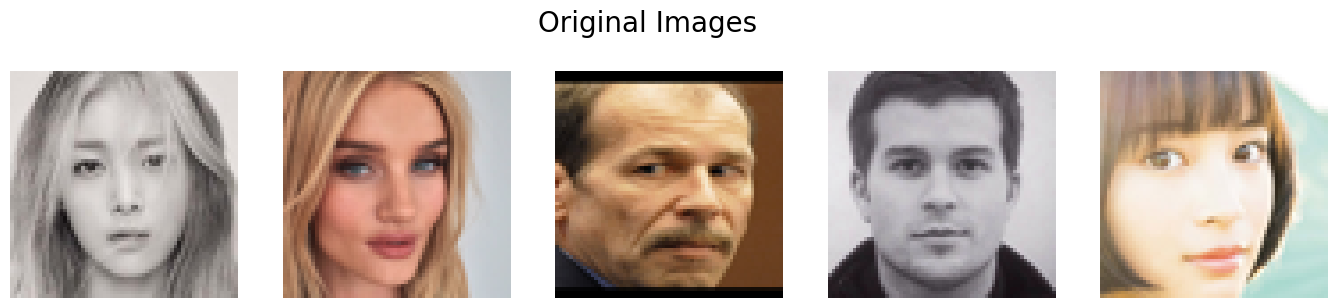

In [253]:
# Displaying Original images
import matplotlib.pyplot  as plt
p = plt.figure(figsize=(17,7))
p.suptitle('Original Images',fontsize=20)
p.subplots_adjust(top=1.35)
for i, imge in enumerate(train_images[:5]):
    sp = p.add_subplot(1,5,i+1)
    plt.imshow(imge)
    plt.axis('off')
plt.show()

# BUILDING MODEL

In [240]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

#sampling
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
#VAE architecture
class VariationalAutoEncoder(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VariationalAutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

In [ ]:
# Encoder model
class Encoder(Model):
    def __init__(self, latent_dim, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.flatten = Flatten()
        self.dense_1 = Dense(256, activation='relu')
        self.dense_mean = Dense(latent_dim)
        self.dense_log_var = Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense_1(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

In [251]:
# Decoder model
class Decoder(Model):
    def __init__(self, original_dim, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense_2 = Dense(256, activation='relu')
        self.dense_output = Dense(original_dim[0] * original_dim[1] * original_dim[2], activation='sigmoid')
        self.reshape = Reshape(original_dim)

    def call(self, inputs):
        x = self.dense_2(inputs)
        x = self.dense_output(x)
        x = self.reshape(x)
        return x

In [ ]:
# Instantiate encoder and decoder
latent_dim = 2
original_dim = (64, 64, 3)
encoder = Encoder(latent_dim)
decoder = Decoder(original_dim)

# Instantiate the VAE model
vae = VariationalAutoEncoder(encoder, decoder)

In [ ]:
# Compiling VAE model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

In [250]:
#Resizing train_images
train_images_resized = tf.image.resize(train_images, (64, 64))
train_images_resized.shape

TensorShape([4027, 64, 64, 3])

In [256]:
#Training VAE
vae.fit(train_images_resized, train_images_resized, epochs=50, batch_size=128)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0657
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0653
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0668
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0659
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0662
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0657
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0657
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0660
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0658
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0662
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0655
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0654
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0654
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0658
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0664
Epo

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


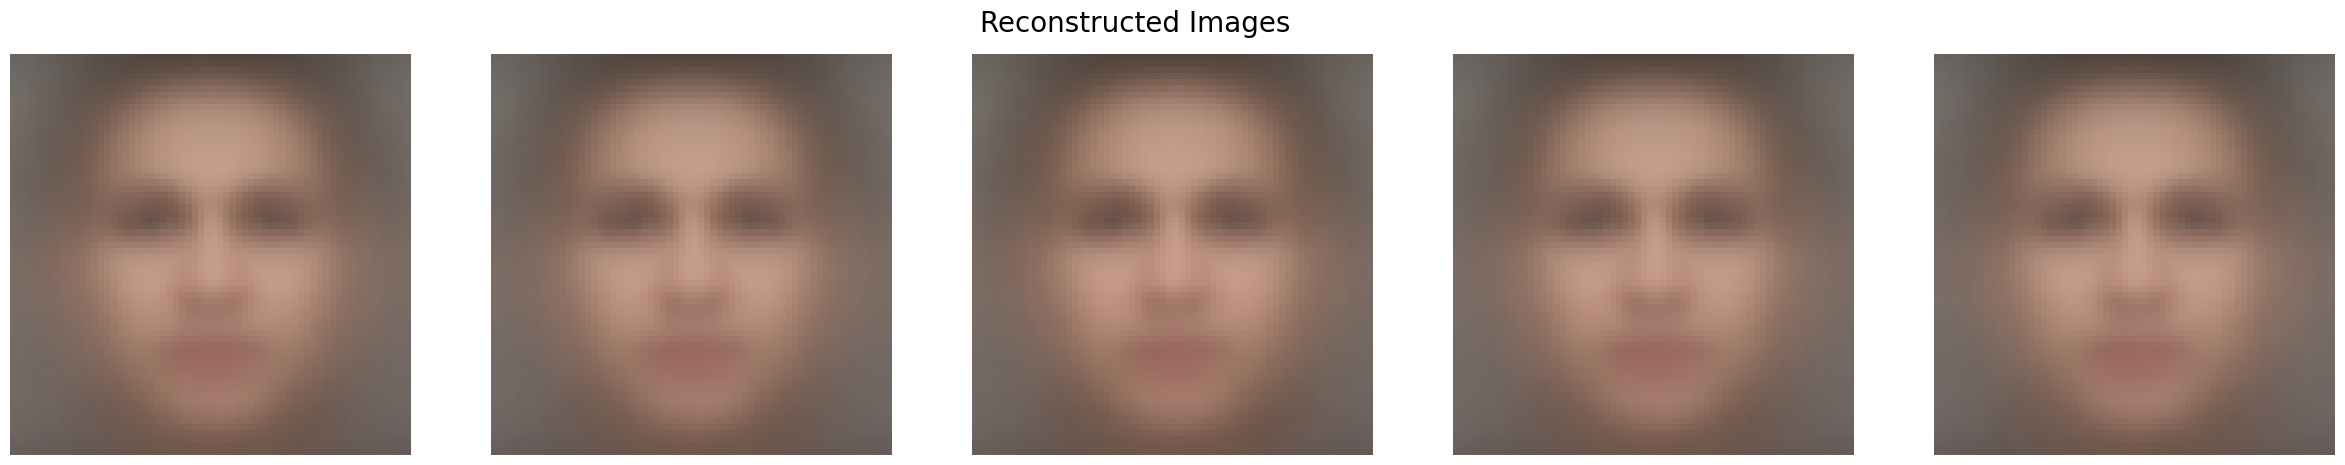

In [264]:
# Plotting reconstructed images
reconstructed_images = vae.predict(train_images_resized)
p = plt.figure(figsize=(30,7))
p.suptitle('Reconstructed Images',fontsize=20)
p.subplots_adjust(top=1.15)
for i, imge in enumerate(reconstructed_images[:5]):
    sp = p.add_subplot(1,5,i+1)
    plt.imshow(imge)
    plt.axis('off')
plt.show()